# Grupo

- Amanda Quirino (aqrs)
- Erlan Lira (elsj)
- Felipe Moraes (fbm3)
- Guilherme Maciel (gmm7)
- Pedro Fonseca (paalf)

# Importando Bibliotecas

In [1]:
import torch, os, datetime, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning, module="optuna")
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Carregando e seperando dataset

In [4]:
batch_size = 32

# Transformações para normalizar o dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para o dataset de treinamento e teste
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = list(map(str, range(0, 10)))

##### Visualizando dados

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


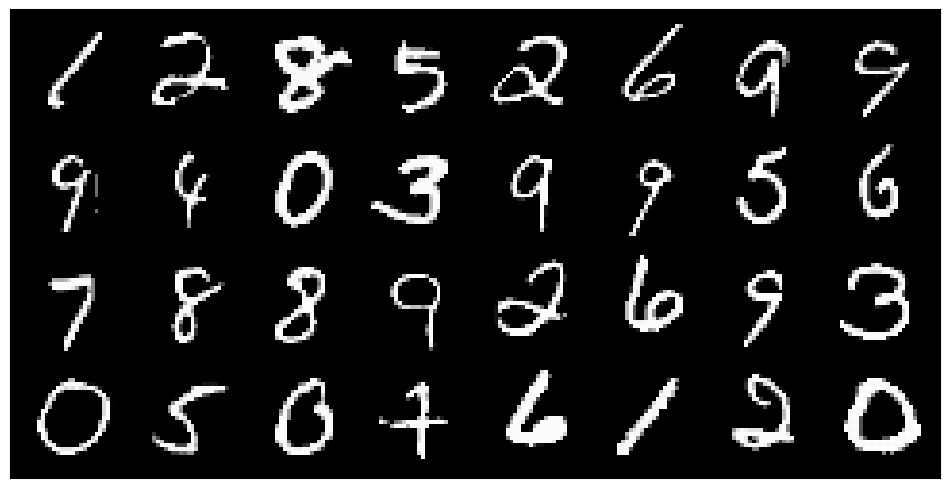

In [6]:
show_batch(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


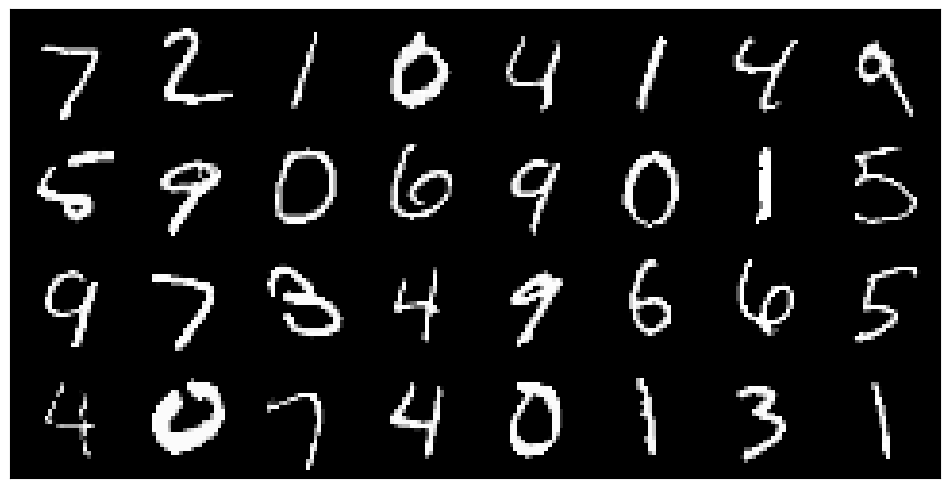

In [7]:
show_batch(testloader)

# Criando uma instância da classe nn.Module para criar redes

#### Explicando cada parâmetro da camada convolucional:

- **in_channels**: Quantos canais de cores os inputs possuem. No caso de imagens em preto e branco, como estamos trabalhando com MNIST, há apenas um canal de cor.

- **out_channels**: Número de filtros (kernels) que serão aplicados à imagem durante a convolução. Cada filtro é responsável por extrair características latentes da imagem.

- **kernel_size**: Dimensão do filtro utilizado na convolução. O valor comum de 3 é amplamente usado, pois é suficiente para capturar detalhes locais, ao mesmo tempo em que percebe padrões maiores na imagem.

- **stride**: Indica de quanto em quantos pixels o filtro será aplicado na imagem.

- **padding**: Adiciona pixels em volta da imagem de entrada durante a convolução para garantir que o tamanho da saída após a convolução permaneça o mesmo que o da entrada.
  - *Observação*: Ao adicionar padding, é preciso ter cuidado com os valores para garantir que a resolução e o tamanho da imagem não sejam afetados de forma indesejada.

- **dropout_prob**: Probabilidade de que um neurônio seja desligado durante o treinamento da rede. Isso é uma técnica de regularização que ajuda a prevenir o overfitting, forçando a rede a aprender representações mais robustas e generalizáveis.

#### Fórmulas das Dimensões de Saída

A fórmula para calcular a dimensão de saída \( W_out \) da convolução é:

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

E a fórmula para calcular a dimensão de saída \( H_out \) da convolução é:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Resumindo as trasnformações:

- Entrada Original: 28x28 pixels, 1 canal.
- Após Convolução: 28x28 pixels, 32 canais.
- Após Pooling: 14x14 pixels, 32 canais.
- Entrada para self.fc1: 32 × 14 × 14

In [8]:
class BaseCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

In [9]:
class DeepCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
class CNN(nn.Module):
    def _calc_conv_output_size(self, in_size, kernel_size, conv_stride, pool_size, pool_stride, padding):
        # Apply convolution
        out_size = (in_size + 2 * padding - kernel_size) // conv_stride + 1
        # Apply pooling
        out_size = (out_size - pool_size) // pool_stride + 1
        return out_size

    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_prob_fc1,
                 conv_kernel_size=3, pool_kernel_size=2, conv_stride=1, pool_stride=2, padding=0):
        super(CNN, self).__init__()

        in_size = 28

        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters[0],
                                              kernel_size=(conv_kernel_size, conv_kernel_size),
                                              stride=conv_stride, padding=padding)])
        out_size = self._calc_conv_output_size(in_size, conv_kernel_size, conv_stride,
                                               pool_kernel_size, pool_stride, padding)

        for i in range(1, num_conv_layers):
            self.convs.append(nn.Conv2d(in_channels=num_filters[i - 1], out_channels=num_filters[i],
                                        kernel_size=(conv_kernel_size, conv_kernel_size),
                                        stride=conv_stride, padding=padding))
            out_size = self._calc_conv_output_size(out_size, conv_kernel_size, conv_stride,
                                                   pool_kernel_size, pool_stride, padding)

        if out_size <= 0:
            raise ValueError("Output size is too small after convolution and pooling operations. " +
                             "Adjust the kernel sizes and strides.")

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)
        self.out_feature = num_filters[num_conv_layers - 1] * out_size * out_size
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.fc1 = nn.Linear(self.out_feature, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.fc1_drop_prob = drop_prob_fc1

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            x = conv(x)
            if i == 2:
                x = self.conv2_drop(x)
            x = F.relu(self.pool(x))

        x = x.view(-1, self.out_feature)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.fc1_drop_prob, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Definindo funções úteis

#### Função de treinamento do modelo

In [11]:
def train_model(model, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in trainloader:
            (inputs, labels) = (inputs.to(device), labels.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()  # Propaga os gradientes
            optimizer.step()  # Atualiza os pesos

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    
    print('Finished Training!')

#### Função de teste do modelo

In [12]:
def test_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    loss = test_loss / len(testloader)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, loss, precision, recall, f1

#### Função de acurácia de cada classe

In [13]:
# Mudar
def accuracy_classes(model_trained):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    all_accuracy = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_trained(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        all_accuracy.append(accuracy)
    
    return all_accuracy

#### Função para prever classe de uma imagem

In [14]:
def predict_image(image_path, model):
    image = Image.open(image_path).convert('L')  
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Adiciona dimensão de batch (1 imagem)
    image = transform(image).unsqueeze(0) 

    # Passando a imagem pela rede
    output = model(image).to(device)

    _, predicted_class = torch.max(output, 1)
    print("Classe prevista:", predicted_class.item())


#### Definindo cvs com os parametros e metricas

In [15]:
if (os.path.exists('cnn_models_metrics.csv')):
    model_df = pd.read_csv('cnn_models_metrics.csv')
else:
    model_data = {
        'network': [],
        'conv_kernel_size': [],
        'conv_stride': [],
        'conv_padding': [],
        'pool_kernel_size': [],
        'pool_stride': [],
        'dropout_prob': [],
        'fit_time': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'overall_accuracy ': [],
        'accuracy_0': [],
        'accuracy_1': [],
        'accuracy_2': [],
        'accuracy_3': [],
        'accuracy_4': [],
        'accuracy_5': [],
        'accuracy_6': [],
        'accuracy_7': [],
        'accuracy_8': [],
        'accuracy_9': [],
        'total_epochs': [],
        'learning_rate': [],
    }
    model_df = pd.DataFrame(model_data)

# Fine-Tuning de Hiperparâmetros

In [36]:
import optuna
from optuna.trial import TrialState

num_epochs = 5
num_trials = 7
criterion = nn.CrossEntropyLoss().to(device)

def train_model_once(model, criterion, optimizer):
    model.train().to(device)

    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    return running_loss / len(trainloader)

def objective(trial):
    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
                   for i in range(num_conv_layers)]
    num_neurons = trial.suggest_int("num_neurons", 10, 400, step=10)  # Number of neurons of fully connected layer 1
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
    drop_fc1 = trial.suggest_float("drop_prob_fc1", 0.2, 0.5)    # Dropout probability for fully connected layer 1

    # conv_kernel_size, conv_stride, padding, pool_kernel_size, pool_stride
    conv_kernel_size = trial.suggest_int("conv_kernel_size", 3, 7, step=2)
    conv_stride = trial.suggest_int("conv_stride", 1, 2) 
    conv_padding = trial.suggest_int("conv_padding", 1, 3)
    pool_kernel_size = trial.suggest_int("pool_kernel_size", 2, 3) 
    pool_stride = trial.suggest_int("pool_stride", 2, 3)

    # Manually add these parameters to the trial's attributes
    trial.set_user_attr("conv_kernel_size", conv_kernel_size)
    trial.set_user_attr("conv_stride", conv_stride)
    trial.set_user_attr("conv_padding", conv_padding)
    trial.set_user_attr("pool_kernel_size", pool_kernel_size)
    trial.set_user_attr("pool_stride", pool_stride)

    try:
        # Generate the model
        model = CNN(trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1,
                    conv_kernel_size, pool_kernel_size, conv_stride, pool_stride, conv_padding).to(device)

        # Generate the optimizer
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

        # Train the model
    
        for epoch in range(num_epochs):
            train_loss = train_model_once(model, criterion, optimizer)
            accuracy, test_loss, precision, recall, f1 = test_model(model, criterion)

            print(f"Epoch {epoch + 1}, " +
                f"Train Loss: {train_loss:.4f}, " + 
                f"Test Loss: {test_loss:.4f}")

            # Pruning (stops trial early if not promising)
            trial.report(accuracy, epoch)
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        trial.set_user_attr("accuracy", accuracy)
        trial.set_user_attr("test_loss", test_loss)
        trial.set_user_attr("precision", precision)
        trial.set_user_attr("recall", recall)
        trial.set_user_attr("f1_score", f1)

        current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        path_model_trained = os.path.join('modelos_treinados', f'optune{current_datetime}.pth')
        torch.save(model.state_dict(), path_model_trained)
        
        return accuracy
    
    except:
        return None

In [37]:
study = optuna.create_study(direction="maximize")

successful_trials = 0
total_trials = 0

while successful_trials < num_trials:
    total_trials += 1
    study.optimize(objective, n_trials=1)
    
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    successful_trials = len(complete_trials)


pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2024-05-22 02:15:59,830] A new study created in memory with name: no-name-56441ee7-8e08-4817-b903-477797ecca7b
C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 2.3067, Test Loss: 2.2911
Epoch 2, Train Loss: 2.2859, Test Loss: 2.2719
Epoch 3, Train Loss: 2.2691, Test Loss: 2.2548
Epoch 4, Train Loss: 2.2522, Test Loss: 2.2387


[I 2024-05-22 02:16:51,668] Trial 0 finished with value: 0.443 and parameters: {'num_conv_layers': 1, 'num_filter_0': 48.0, 'num_neurons': 230, 'drop_conv2': 0.32998893700681453, 'drop_prob_fc1': 0.40980489324582714, 'conv_kernel_size': 3, 'conv_stride': 2, 'conv_padding': 1, 'pool_kernel_size': 3, 'pool_stride': 3, 'optimizer': 'SGD', 'lr': 4.537540113303237e-05}. Best is trial 0 with value: 0.443.


Epoch 5, Train Loss: 2.2369, Test Loss: 2.2231


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 0.2264, Test Loss: 0.0675
Epoch 2, Train Loss: 0.1082, Test Loss: 0.0462
Epoch 3, Train Loss: 0.0884, Test Loss: 0.0453
Epoch 4, Train Loss: 0.0787, Test Loss: 0.0503


[I 2024-05-22 02:17:44,309] Trial 1 finished with value: 0.9874 and parameters: {'num_conv_layers': 1, 'num_filter_0': 48.0, 'num_neurons': 90, 'drop_conv2': 0.3320717173257355, 'drop_prob_fc1': 0.3701865760116463, 'conv_kernel_size': 7, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 0.0007089484635809396}. Best is trial 1 with value: 0.9874.


Epoch 5, Train Loss: 0.0687, Test Loss: 0.0437


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 0.4567, Test Loss: 0.1418
Epoch 2, Train Loss: 0.1436, Test Loss: 0.0939
Epoch 3, Train Loss: 0.1074, Test Loss: 0.0803
Epoch 4, Train Loss: 0.0894, Test Loss: 0.0667


[I 2024-05-22 02:18:55,248] Trial 2 finished with value: 0.9815 and parameters: {'num_conv_layers': 1, 'num_filter_0': 48.0, 'num_neurons': 290, 'drop_conv2': 0.34596892993742856, 'drop_prob_fc1': 0.31217914567654786, 'conv_kernel_size': 5, 'conv_stride': 2, 'conv_padding': 2, 'pool_kernel_size': 3, 'pool_stride': 3, 'optimizer': 'RMSprop', 'lr': 0.0001038185889077277}. Best is trial 1 with value: 0.9874.


Epoch 5, Train Loss: 0.0765, Test Loss: 0.0598


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 0.6977, Test Loss: 0.0905
Epoch 2, Train Loss: 0.2282, Test Loss: 0.0675
Epoch 3, Train Loss: 0.1611, Test Loss: 0.0638
Epoch 4, Train Loss: 0.1320, Test Loss: 0.0725


[I 2024-05-22 02:21:06,388] Trial 3 finished with value: 0.9824 and parameters: {'num_conv_layers': 1, 'num_filter_0': 32.0, 'num_neurons': 60, 'drop_conv2': 0.29878373599967406, 'drop_prob_fc1': 0.420249504666099, 'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 0.004143035600326356}. Best is trial 1 with value: 0.9874.


Epoch 5, Train Loss: 0.1242, Test Loss: 0.0665


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 1.1454, Test Loss: 0.3461
Epoch 2, Train Loss: 0.3005, Test Loss: 0.1768
Epoch 3, Train Loss: 0.1925, Test Loss: 0.1265
Epoch 4, Train Loss: 0.1483, Test Loss: 0.1009


[I 2024-05-22 02:23:10,255] Trial 4 finished with value: 0.9744 and parameters: {'num_conv_layers': 2, 'num_filter_0': 64.0, 'num_filter_1': 32.0, 'num_neurons': 240, 'drop_conv2': 0.49652760499849974, 'drop_prob_fc1': 0.31108683596259445, 'conv_kernel_size': 7, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 3, 'pool_stride': 3, 'optimizer': 'Adam', 'lr': 1.7896142595502347e-05}. Best is trial 1 with value: 0.9874.
C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:23:10,260] Trial 5 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 16.0, 'num_filter_1': 64.0, 'num_neurons': 400, 'drop_conv2': 0.34884105781513486, 'drop_prob_fc1': 0.2

Epoch 5, Train Loss: 0.1238, Test Loss: 0.0859
Epoch 1, Train Loss: 0.2348, Test Loss: 0.0863
Epoch 2, Train Loss: 0.1351, Test Loss: 0.0662
Epoch 3, Train Loss: 0.1202, Test Loss: 0.0648
Epoch 4, Train Loss: 0.1141, Test Loss: 0.1044


[I 2024-05-22 02:25:15,385] Trial 6 finished with value: 0.9847 and parameters: {'num_conv_layers': 2, 'num_filter_0': 96.0, 'num_filter_1': 112.0, 'num_neurons': 110, 'drop_conv2': 0.40701100728048856, 'drop_prob_fc1': 0.45263903459307314, 'conv_kernel_size': 7, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'Adam', 'lr': 0.002856427589231605}. Best is trial 1 with value: 0.9874.


Epoch 5, Train Loss: 0.1062, Test Loss: 0.0744


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:25:38,394] Trial 7 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_neurons': 180, 'drop_conv2': 0.30690105693800934, 'drop_prob_fc1': 0.42059500901259106, 'conv_kernel_size': 5, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 0.036471909415342216} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:25:38,395] Trial 7 failed with value None.


Epoch 1, Train Loss: 367.0293, Test Loss: 2.3087


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:26:03,625] Trial 8 failed with parameters: {'num_conv_layers': 3, 'num_filter_0': 32.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'num_neurons': 180, 'drop_conv2': 0.4781757897604015, 'drop_prob_fc1': 0.427898404698852, 'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'Adam', 'lr': 3.2986311533956956e-05} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:26:03,626] Trial 8 failed with value None.


Epoch 1, Train Loss: 0.7946, Test Loss: 0.1716


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:26:29,022] Trial 9 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 96.0, 'num_filter_1': 16.0, 'num_neurons': 70, 'drop_conv2': 0.3722316496347039, 'drop_prob_fc1': 0.26079181204078383, 'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 3, 'pool_stride': 3, 'optimizer': 'RMSprop', 'lr': 0.0003533524877348309} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:26:29,023] Trial 9 failed with value None.
C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprec

Epoch 1, Train Loss: 0.3701, Test Loss: 0.1086


[W 2024-05-22 02:26:55,397] Trial 12 failed with parameters: {'num_conv_layers': 3, 'num_filter_0': 80.0, 'num_filter_1': 64.0, 'num_filter_2': 64.0, 'num_neurons': 10, 'drop_conv2': 0.3902067488424914, 'drop_prob_fc1': 0.4840400793881832, 'conv_kernel_size': 3, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 0.0002879752558222546} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:26:55,398] Trial 12 failed with value None.


Epoch 1, Train Loss: 1.5025, Test Loss: 0.5643


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:27:19,496] Trial 13 failed with parameters: {'num_conv_layers': 3, 'num_filter_0': 32.0, 'num_filter_1': 48.0, 'num_filter_2': 48.0, 'num_neurons': 250, 'drop_conv2': 0.4095461626860909, 'drop_prob_fc1': 0.2773058120190334, 'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 2.4545044236357354e-05} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:27:19,497] Trial 13 failed with value None.


Epoch 1, Train Loss: 0.8955, Test Loss: 0.1937


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 0.4147, Test Loss: 0.0835


[W 2024-05-22 02:28:03,032] Trial 14 failed with parameters: {'num_conv_layers': 1, 'num_filter_0': 64.0, 'num_neurons': 200, 'drop_conv2': 0.3184712156175844, 'drop_prob_fc1': 0.4784241939700152, 'conv_kernel_size': 3, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'RMSprop', 'lr': 0.0016935195947893873} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:28:03,033] Trial 14 failed with value None.


Epoch 2, Train Loss: 0.1438, Test Loss: 0.0737


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:28:25,247] Trial 15 failed with parameters: {'num_conv_layers': 1, 'num_filter_0': 48.0, 'num_neurons': 200, 'drop_conv2': 0.42841229398619635, 'drop_prob_fc1': 0.28036569445088816, 'conv_kernel_size': 7, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'SGD', 'lr': 0.00026449917576624896} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:28:25,248] Trial 15 failed with value None.
C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This 

Epoch 1, Train Loss: 1.8508, Test Loss: 1.3851


[W 2024-05-22 02:28:46,645] Trial 17 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_neurons': 80, 'drop_conv2': 0.23769156668678612, 'drop_prob_fc1': 0.28117775554861457, 'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 3, 'pool_stride': 3, 'optimizer': 'RMSprop', 'lr': 0.00017716120822763713} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:28:46,645] Trial 17 failed with value None.


Epoch 1, Train Loss: 0.6813, Test Loss: 0.2028


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:29:10,919] Trial 18 failed with parameters: {'num_conv_layers': 3, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'num_filter_2': 16.0, 'num_neurons': 350, 'drop_conv2': 0.3729521622795822, 'drop_prob_fc1': 0.2685712054844358, 'conv_kernel_size': 5, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 2, 'pool_stride': 2, 'optimizer': 'SGD', 'lr': 0.0004234494491972966} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:29:10,919] Trial 18 failed with value None.


Epoch 1, Train Loss: 2.3021, Test Loss: 2.2980


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:29:32,158] Trial 19 failed with parameters: {'num_conv_layers': 1, 'num_filter_0': 112.0, 'num_neurons': 70, 'drop_conv2': 0.3385649174623317, 'drop_prob_fc1': 0.2030588327287124, 'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 3, 'optimizer': 'Adam', 'lr': 0.012911972962128484} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:29:32,159] Trial 19 failed with value None.


Epoch 1, Train Loss: 0.3892, Test Loss: 0.2347


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:29:55,936] Trial 20 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 128.0, 'num_filter_1': 64.0, 'num_neurons': 20, 'drop_conv2': 0.44220521037882743, 'drop_prob_fc1': 0.20308144764199842, 'conv_kernel_size': 3, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 2, 'pool_stride': 3, 'optimizer': 'Adam', 'lr': 0.012899098532640601} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:29:55,938] Trial 20 failed with value None.


Epoch 1, Train Loss: 1.1457, Test Loss: 0.6491


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:30:13,346] Trial 21 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_neurons': 210, 'drop_conv2': 0.3050231059093987, 'drop_prob_fc1': 0.253766364329552, 'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 3, 'optimizer': 'SGD', 'lr': 0.0002503228428488436} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:30:13,347] Trial 21 failed with value None.
[W 2024-05-22 02:30:37,302] Trial 22 failed with parameters: {'num_conv_layers': 2, 'num_filter_0': 32.0, 'num_filter_1': 128.

Epoch 1, Train Loss: 2.9224, Test Loss: 2.3095


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
[W 2024-05-22 02:31:03,282] Trial 23 failed with parameters: {'num_conv_layers': 1, 'num_filter_0': 128.0, 'num_neurons': 260, 'drop_conv2': 0.3421608081374433, 'drop_prob_fc1': 0.4931497388406901, 'conv_kernel_size': 5, 'conv_stride': 2, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'optimizer': 'Adam', 'lr': 0.03158709164817984} because of the following error: The value None could not be cast to float..
[W 2024-05-22 02:31:03,283] Trial 23 failed with value None.


Epoch 1, Train Loss: 2.3135, Test Loss: 2.3029


C:\Users\Amand\AppData\Local\Temp\ipykernel_11184\3099919600.py:29: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))


Epoch 1, Train Loss: 0.2757, Test Loss: 0.0751
Epoch 2, Train Loss: 0.1131, Test Loss: 0.0535
Epoch 3, Train Loss: 0.0875, Test Loss: 0.0560
Epoch 4, Train Loss: 0.0708, Test Loss: 0.0518


[I 2024-05-22 02:33:05,425] Trial 24 finished with value: 0.9857 and parameters: {'num_conv_layers': 1, 'num_filter_0': 64.0, 'num_neurons': 390, 'drop_conv2': 0.37441432374210604, 'drop_prob_fc1': 0.4739465451080359, 'conv_kernel_size': 3, 'conv_stride': 2, 'conv_padding': 3, 'pool_kernel_size': 3, 'pool_stride': 2, 'optimizer': 'Adam', 'lr': 0.0009808734654104668}. Best is trial 1 with value: 0.9874.


Epoch 5, Train Loss: 0.0615, Test Loss: 0.0441


In [38]:
# Save results to csv file
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df["total_epochs"] = num_epochs
df = df.sort_values("value")  # Sort based on accuracy

csv_file = "optuna_results.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

# Estatísticas

In [21]:
print("\n-- Study Statistics --")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials:   {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.value}")
print(f"  Test Loss: {best_trial.user_attrs['test_loss']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1_score']}")
print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")
print(f"  conv_kernel_size: {best_trial.user_attrs['conv_kernel_size']}")
print(f"  conv_stride:      {best_trial.user_attrs['conv_stride']}")
print(f"  conv_padding:     {best_trial.user_attrs['conv_padding']}")
print(f"  pool_kernel_size: {best_trial.user_attrs['pool_kernel_size']}")
print(f"  pool_stride:      {best_trial.user_attrs['pool_stride']}")

# Save results to csv file
df = study.trials_dataframe().drop(["datetime_start", "datetime_complete", "duration"], axis=1)
df = df.loc[df["state"] == "COMPLETE"]  # Keep only results that did not prune
df = df.drop("state", axis=1)
df = df.sort_values("value")            # Sort based on accuracy

# if not os.path.exists("optuna_results.csv"):
#     df.to_csv("optuna_results.csv", index=False)
# else:
#     df = pd.concat([pd.read_csv("optuna_results.csv"), df], axis=0, join='outer')

print(f"\n-- Overall Results (Ordered by Accuracy) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Study Statistics --
  Number of finished trials: 17
  Number of pruned trials:   0
  Number of complete trials: 10

-- Best Trial --
  Accuracy:  0.9939
  Test Loss: 0.01865785698586538
  Precision: 0.9939123718919359
  Recall:    0.9939
  F1 Score:  0.9938953339778455
  Parameters: 
    num_conv_layers:  3
    num_filter_0:     32.0
    num_filter_1:     64.0
    num_filter_2:     96.0
    num_neurons:      280
    drop_conv2:       0.437103990879252
    drop_prob_fc1:    0.4098801964601213
    conv_kernel_size: 5
    conv_stride:      1
    conv_padding:     3
    pool_kernel_size: 3
    pool_stride:      2
    optimizer:        SGD
    lr:               0.046106590474024274
  conv_kernel_size: 5
  conv_stride:      1
  conv_padding:     3
  pool_kernel_size: 3
  pool_stride:      2

-- Overall Results (Ordered by Accuracy) --
    number   value  params_conv_kernel_size  params_conv_padding  \
2        2  0.2441                        3                    3   
4        4  0.9502 

# One Model

#### Instânciando o modelo base, definindo parametros, loss function e otimizador

In [19]:
model = BaseCNN().to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Treinamento o modelo

In [20]:
train_model(model, criterion, optimizer, epochs)

Epoch 1, Loss: 0.384782139168183
Epoch 2, Loss: 0.23831701233883698
Epoch 3, Loss: 0.1912519934932391
Epoch 4, Loss: 0.16461124399056037
Epoch 5, Loss: 0.14714536422590416
Epoch 6, Loss: 0.13749022841975092
Epoch 7, Loss: 0.1272109903064867
Epoch 8, Loss: 0.11995212206194798
Epoch 9, Loss: 0.11432278891926011
Epoch 10, Loss: 0.10794405772338311
Finished Training!


#### Testando o modelo

In [21]:
accuracy, loss, precision, recall, f1 = test_model(model, criterion)
print(f'Accuracy: {100 * accuracy}%, Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 97.61%, Test Loss: 0.0799, Precision: 0.9762, Recall: 0.9761, F1 Score: 0.9761


## Salvando o modelo treinado

In [22]:
if not os.path.exists('modelos_treinados'):
    os.makedirs('modelos_treinados')

current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
path_model_trained = os.path.join('modelos_treinados', f'model_{current_datetime}.pth')

torch.save(model.state_dict(), path_model_trained)

# N Models

#### Função de criação de derivação da rede base

In [23]:
def create_cnn(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob):
    class CNNTest(BaseCNN):
        def __init__(self):
            super(CNNTest, self).__init__(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob)
    return CNNTest().to(device)

#### Instanciando os modelos com grid de parametros

In [24]:
grid = [
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5},
    {'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3},
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.7}
]
networks = [create_cnn(**params) for params in grid]

#### Definindo parametros adicionais, loss function e otimizadores

In [25]:
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) for model in networks]

#### Treinando e testando os modelos

In [26]:
for i, net in enumerate(networks):
    print(f"Treinando Rede Neural {i + 1} com os seguintes parâmetros:")
    print(grid[i])

    start = time.time()
    train_model(net, criterion, optimizers[i], epochs)
    end = time.time()
    total_time = round(end - start, 1)

    accuracy, loss, precision, recall, f1 = test_model(net, criterion)
    print(f'Accuracy: {100 * accuracy}% Test Loss: {loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f} Fit Time: {total_time}')
    print('------------------------------------\n')

    class_accuracies = accuracy_classes(net)

    model_data  = {
        'network': [], #colocar como é a rede, podemos criar um nome pra cada rede e por ou algo do genero
        **grid[i],
        'fit_time': total_time,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overall_accuracy ': accuracy,
        'loss': loss,
        'total_epochs': epochs,
        'learning_rate': learning_rate,
    }

    for idx, acc in enumerate(class_accuracies):
        model_data[f'accuracy_{idx}'] = acc

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = model_data

Treinando Rede Neural 1 com os seguintes parâmetros:
{'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5}
Epoch 1, Loss: 0.35869523210128146
Epoch 2, Loss: 0.22594005839725337
Epoch 3, Loss: 0.1822856837068995
Epoch 4, Loss: 0.15789351285398007
Epoch 5, Loss: 0.1432555805993577
Epoch 6, Loss: 0.13015948122292756
Epoch 7, Loss: 0.12193328732376298
Epoch 8, Loss: 0.11608865336080393
Epoch 9, Loss: 0.11089956559290488
Epoch 10, Loss: 0.10692115652188659
Finished Training!
Accuracy: 97.61% Test Loss: 0.0787 Precision: 0.9761 Recall: 0.9761 F1 Score: 0.9761 Fit Time: 86.3
------------------------------------

Treinando Rede Neural 2 com os seguintes parâmetros:
{'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3}
Epoch 1, Loss: 0.32763771085739135
Epoch 2, Loss: 0.18061796630422275
Epoch 3, Loss: 0.13966323005060355
Epoch 4, Loss: 0.11693177247196436
Ep

In [27]:
model_df.to_csv('cnn_models_metrics.csv', index=False)

## Carregando modelo treinado

In [28]:
# path_model_trained = 'modelos_treinados\model_20240520_214724.pth'

model_trained = BaseCNN().to(device)
model_trained.load_state_dict(torch.load(path_model_trained))
model_trained.eval()

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

#### Prevendo a classe de uma entrada

#### Analisando acurácia de cada classe

In [29]:
all_accuracy = accuracy_classes(model_trained)
for i, accuracy in enumerate(all_accuracy):
    print(f'Accuracy for class: {i} is {accuracy:.2f} %')

Accuracy for class: 0 is 99.18 %
Accuracy for class: 1 is 99.03 %
Accuracy for class: 2 is 97.58 %
Accuracy for class: 3 is 97.62 %
Accuracy for class: 4 is 98.37 %
Accuracy for class: 5 is 97.09 %
Accuracy for class: 6 is 98.23 %
Accuracy for class: 7 is 97.18 %
Accuracy for class: 8 is 96.41 %
Accuracy for class: 9 is 95.24 %


# Análise dos Resultados

In [39]:
df = pd.read_csv('optuna_results.csv')
df.sort_values(by=['number'], inplace=True)
df.columns

Index(['number', 'value', 'params_conv_kernel_size', 'params_conv_padding',
       'params_conv_stride', 'params_drop_conv2', 'params_drop_prob_fc1',
       'params_lr', 'params_num_conv_layers', 'params_num_filter_0',
       'params_num_filter_1', 'params_num_filter_2', 'params_num_neurons',
       'params_optimizer', 'params_pool_kernel_size', 'params_pool_stride',
       'user_attrs_accuracy', 'user_attrs_conv_kernel_size',
       'user_attrs_conv_padding', 'user_attrs_conv_stride',
       'user_attrs_f1_score', 'user_attrs_pool_kernel_size',
       'user_attrs_pool_stride', 'user_attrs_precision', 'user_attrs_recall',
       'user_attrs_test_loss', 'total_epochs'],
      dtype='object')

In [40]:
df

,number,value,params_conv_kernel_size,params_conv_padding,params_conv_stride,params_drop_conv2,params_drop_prob_fc1,params_lr,params_num_conv_layers,params_num_filter_0,...,user_attrs_conv_kernel_size,user_attrs_conv_padding,user_attrs_conv_stride,user_attrs_f1_score,user_attrs_pool_kernel_size,user_attrs_pool_stride,user_attrs_precision,user_attrs_recall,user_attrs_test_loss,total_epochs
0,2,0.2441,3,3,1,0.426414,0.301868,0.012769,1,80.0,...,3,3,1,0.136113,3,3,0.199311,0.2441,1.748456,5
8,3,0.9930,7,3,1,0.232044,0.310813,0.000597,3,64.0,...,7,3,1,0.992997,2,2,0.993028,0.9930,0.027143,5
1,4,0.9502,5,3,1,0.421362,0.463062,0.004871,3,80.0,...,5,3,1,0.950140,3,2,0.951463,0.9502,0.184708,5
3,5,0.9631,7,2,2,0.417490,0.424494,0.002563,2,32.0,...,7,2,2,0.963061,2,2,0.963239,0.9631,0.128284,5
2,6,0.9619,5,3,2,0.331002,0.364276,0.000015,3,96.0,...,5,3,2,0.961834,2,2,0.961981,0.9619,0.122138,5
7,7,0.9912,7,3,1,0.280097,0.200565,0.050783,1,112.0,...,7,3,1,0.991202,2,3,0.991216,0.9912,0.028763,5
4,10,0.9823,5,1,1,0.378162,0.264879,0.000032,3,80.0,...,5,1,1,0.982296,2,2,0.982350,0.9823,0.055292,5
9,11,0.9939,5,3,1,0.437104,0.409880,0.046107,3,32.0,...,5,3,1,0.993895,3,2,0.993912,0.9939,0.018658,5
5,15,0.9872,7,1,2,0.348643,0.320251,0.002183,1,80.0,...,7,1,2,0.987188,3,3,0.987328,0.9872,0.049583,5
6,16,0.9910,7,3,1,0.396759,0.315915,0.000427,2,112.0,...,7,3,1,0.991000,3,2,0.991025,0.9910,0.030439,5


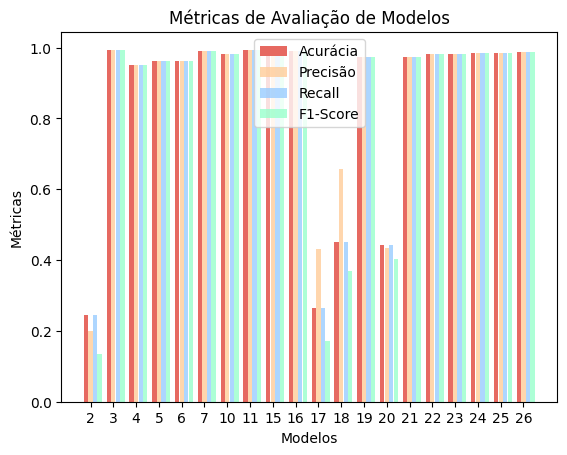

In [41]:
x = np.arange(len(df['number']))
width = 0.2  # Largura das barras

fig, ax = plt.subplots()
bars4 = ax.bar(x - width, df['user_attrs_accuracy'], width - 0.01, label='Acurácia', color=(0.9, 0.41, 0.38))
bars2 = ax.bar(x, df['user_attrs_precision'], width - 0.01, label='Precisão', color=(1.0, 0.8, 0.6, 0.8))
bars1 = ax.bar(x + width, df['user_attrs_recall'], width - 0.01, label='Recall', color=(0.6, 0.8, 1.0, 0.8))
bars3 = ax.bar(x + 2*width, df['user_attrs_f1_score'], width - 0.01, label='F1-Score', color=(0.6, 1.0, 0.8, 0.8))

ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Avaliação de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df['number'])
ax.legend()

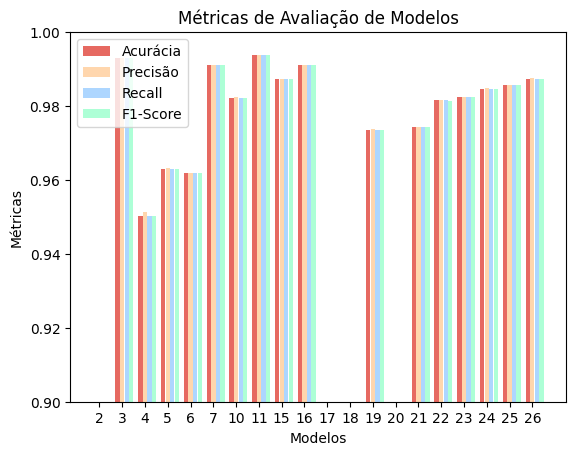

In [42]:
fig, ax = plt.subplots()
bars4 = ax.bar(x - width, df['user_attrs_accuracy'], width - 0.01, label='Acurácia', color=(0.9, 0.41, 0.38))
bars2 = ax.bar(x, df['user_attrs_precision'], width - 0.01, label='Precisão', color=(1.0, 0.8, 0.6, 0.8))
bars1 = ax.bar(x + width, df['user_attrs_recall'], width - 0.01, label='Recall', color=(0.6, 0.8, 1.0, 0.8))
bars3 = ax.bar(x + 2*width, df['user_attrs_f1_score'], width - 0.01, label='F1-Score', color=(0.6, 1.0, 0.8, 0.8))

ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Avaliação de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df['number'])
ax.set_ylim(0.9, 1.0)
ax.legend()

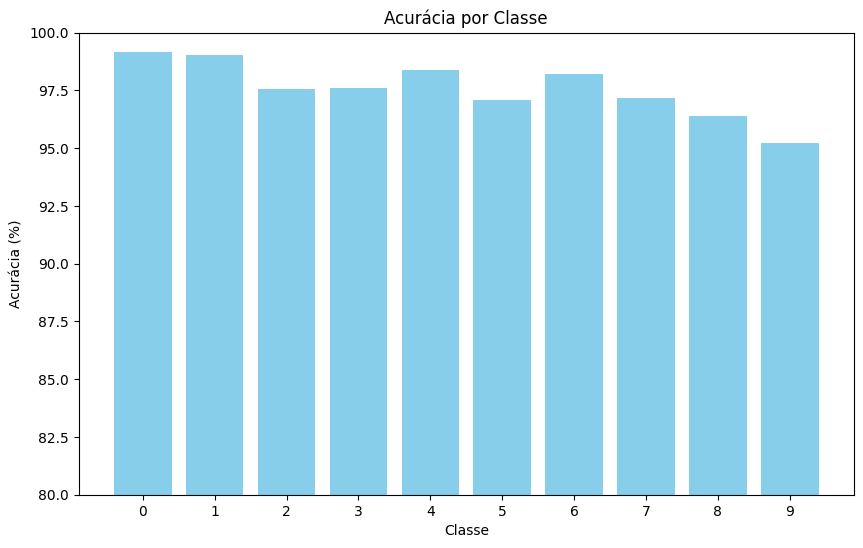

In [47]:
acc_data = pd.DataFrame(all_accuracy, columns=['Acurácia'])

plt.figure(figsize=(10, 6))
plt.bar(acc_data.index, acc_data['Acurácia'], color='skyblue')

# Adicionando títulos e rótulos
plt.title('Acurácia por Classe')
plt.xlabel('Classe')
plt.ylabel('Acurácia (%)')
plt.xticks(acc_data.index)
plt.ylim(80, 100)

# Mostrando o gráfico
plt.show()

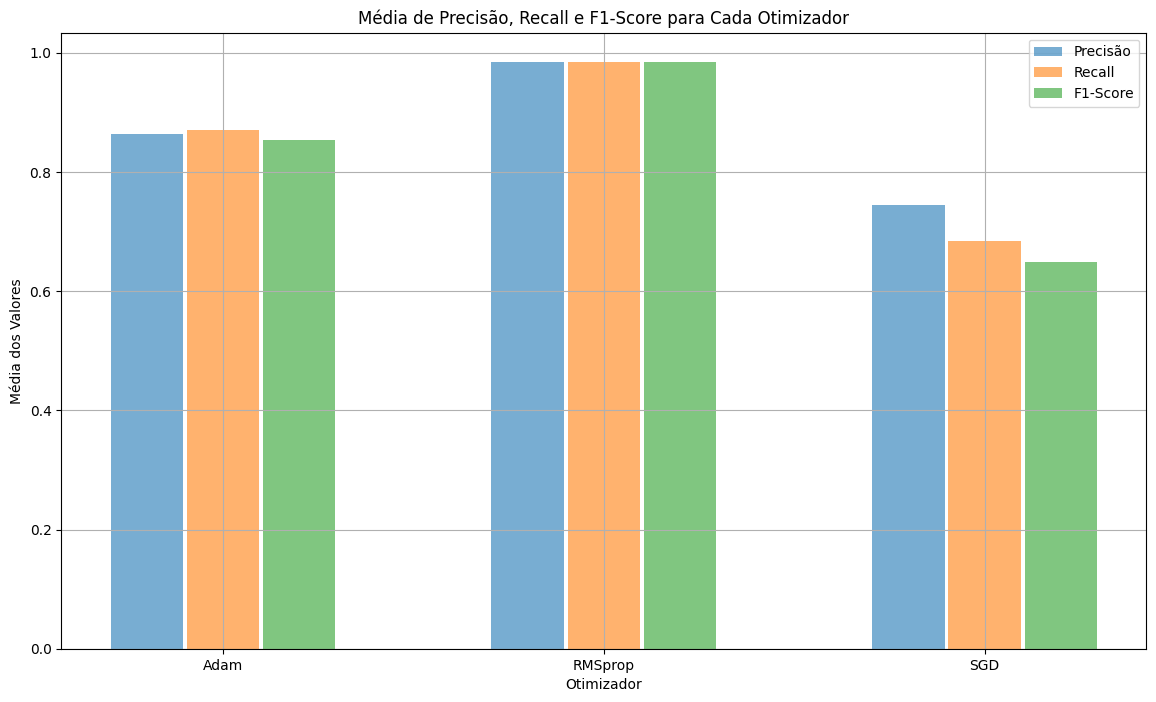

In [43]:
# Agrupar por otimizador e calcular médias
optimizer_group = df.groupby('params_optimizer').mean()

r1 = np.arange(len(optimizer_group.index))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]


# Gráfico de barras
plt.figure(figsize=(14, 8))

# Precisão
plt.bar(r1, optimizer_group['user_attrs_precision'], width - 0.01, label='Precisão', alpha=0.6)

# Recall
plt.bar(r2, optimizer_group['user_attrs_recall'], width - 0.01, label='Recall', alpha=0.6)

# F1-score
plt.bar(r3, optimizer_group['user_attrs_f1_score'], width - 0.01, label='F1-Score', alpha=0.6)

plt.xlabel('Otimizador')
plt.ylabel('Média dos Valores')
plt.title('Média de Precisão, Recall e F1-Score para Cada Otimizador')
plt.xticks([r + width for r in range(len(optimizer_group.index))], optimizer_group.index)
plt.legend()
plt.grid(True)
plt.show()


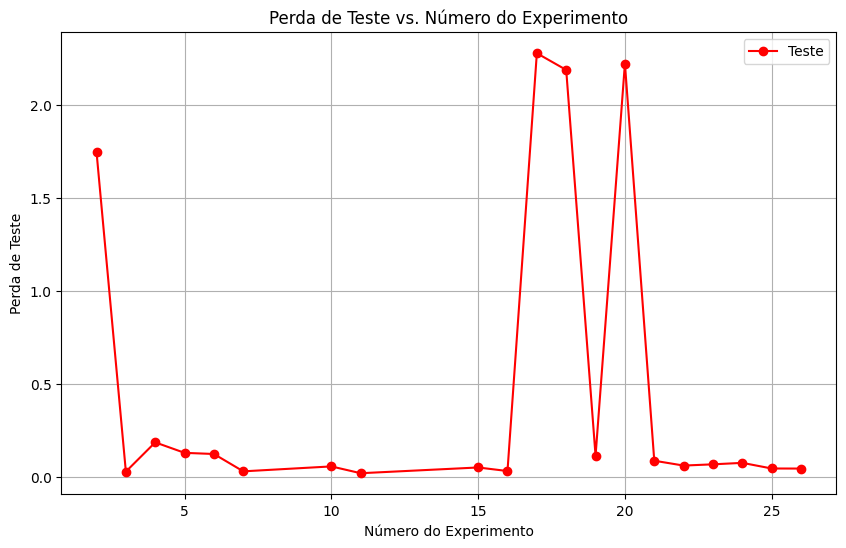

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(df['number'], df['user_attrs_test_loss'], marker='o', linestyle='-', color='red')
plt.xlabel('Número do Experimento')
plt.ylabel('Perda de Teste')
plt.title('Perda de Teste vs. Número do Experimento')
plt.legend(['Teste'])
plt.grid(True)
plt.show()

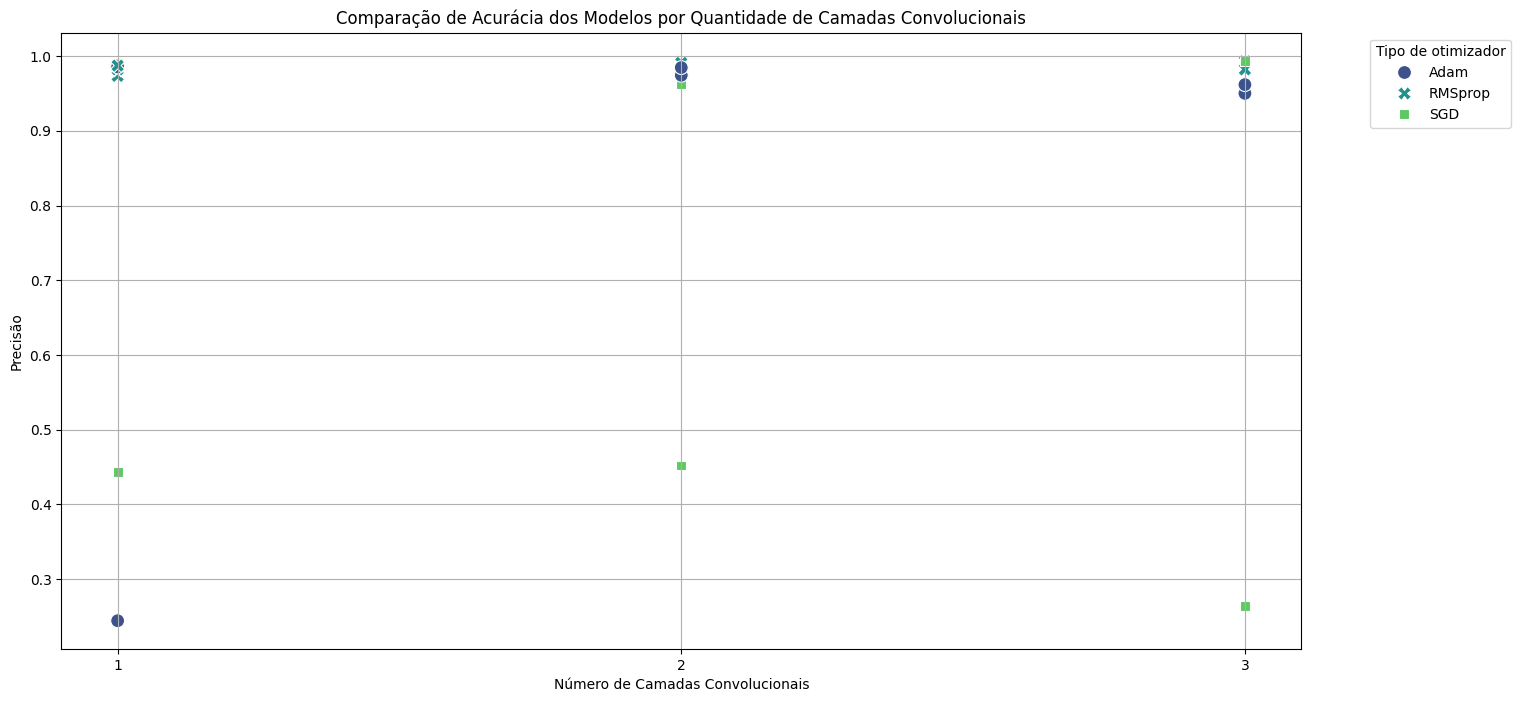

In [45]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_num_conv_layers', y='user_attrs_accuracy', hue='params_optimizer', style='params_optimizer', markers=True,
                palette='viridis', s=100)

plt.title('Comparação de Acurácia dos Modelos por Quantidade de Camadas Convolucionais')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Acurácia')
plt.xticks(df['params_num_conv_layers'].unique())
plt.grid(True)
plt.legend(title='Tipo de otimizador', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

In [51]:
df.columns

Index(['number', 'value', 'params_conv_kernel_size', 'params_conv_padding',
       'params_conv_stride', 'params_drop_conv2', 'params_drop_prob_fc1',
       'params_lr', 'params_num_conv_layers', 'params_num_filter_0',
       'params_num_filter_1', 'params_num_filter_2', 'params_num_neurons',
       'params_optimizer', 'params_pool_kernel_size', 'params_pool_stride',
       'user_attrs_accuracy', 'user_attrs_conv_kernel_size',
       'user_attrs_conv_padding', 'user_attrs_conv_stride',
       'user_attrs_f1_score', 'user_attrs_pool_kernel_size',
       'user_attrs_pool_stride', 'user_attrs_precision', 'user_attrs_recall',
       'user_attrs_test_loss', 'total_epochs'],
      dtype='object')

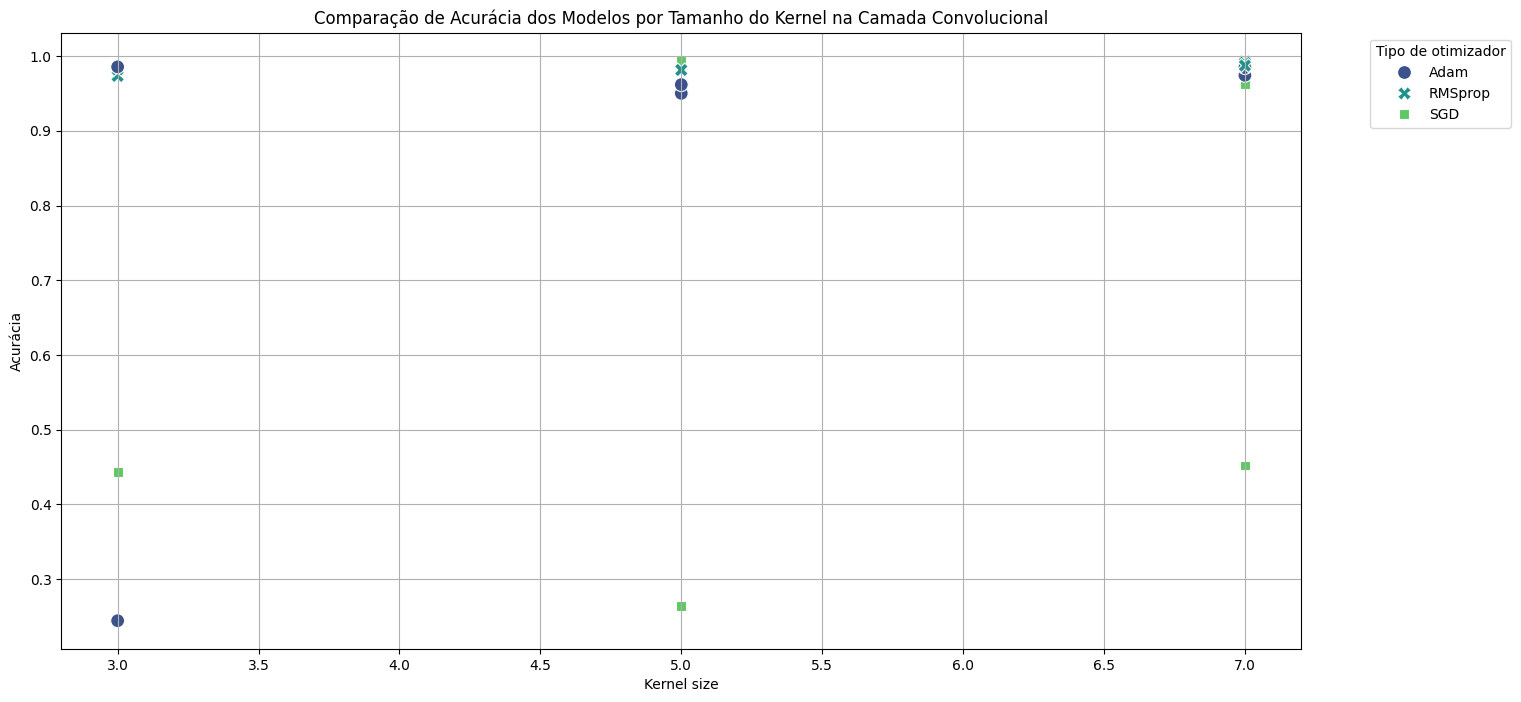

In [53]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_conv_kernel_size', y='user_attrs_accuracy', hue='params_optimizer', style='params_optimizer', markers=True,
                palette='viridis', s=100)

plt.title('Comparação de Acurácia dos Modelos por Tamanho do Kernel na Camada Convolucional')
plt.xlabel('Kernel size')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(title='Tipo de otimizador', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

In [47]:
data = pd.DataFrame(df.groupby('params_num_conv_layers')['user_attrs_accuracy'].mean().reset_index())

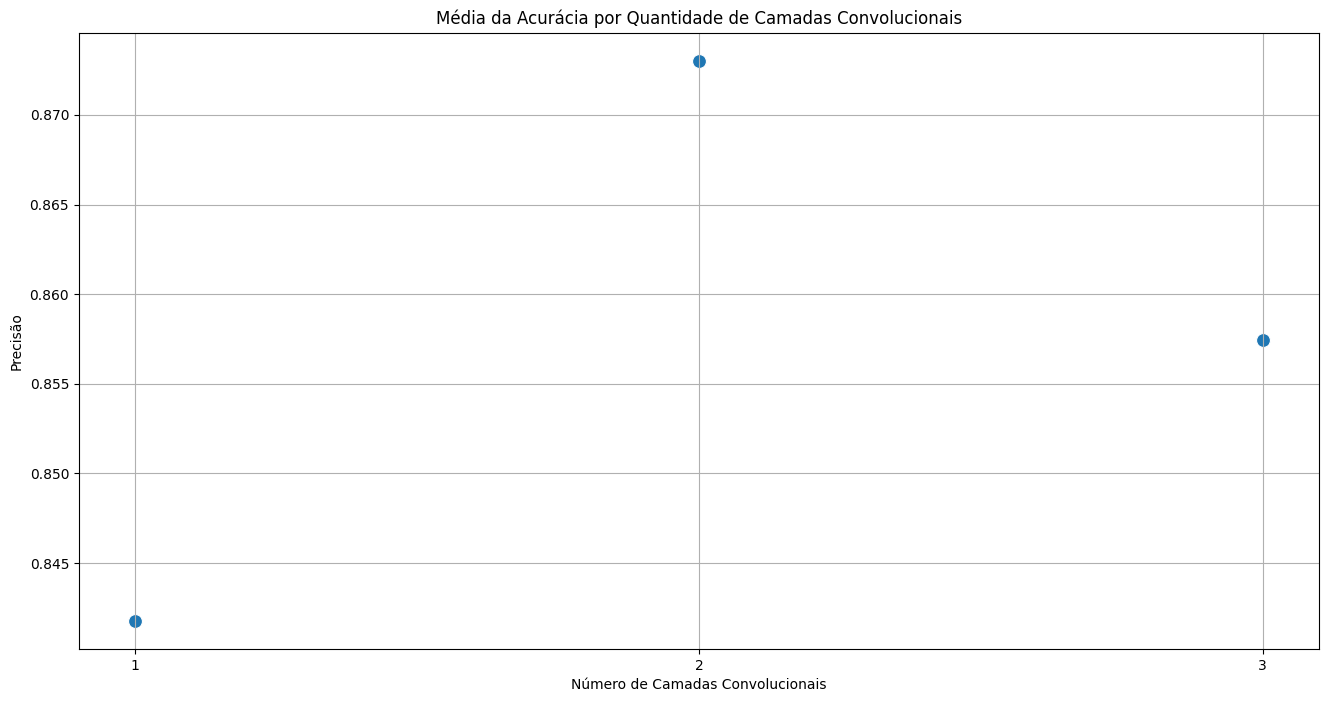

In [48]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=data, x='params_num_conv_layers', y='user_attrs_accuracy', markers=True,
                 s=100)

plt.title('Média da Acurácia por Quantidade de Camadas Convolucionais')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Precisão')
plt.xticks(df['params_num_conv_layers'].unique())
plt.grid(True)

plt.show()

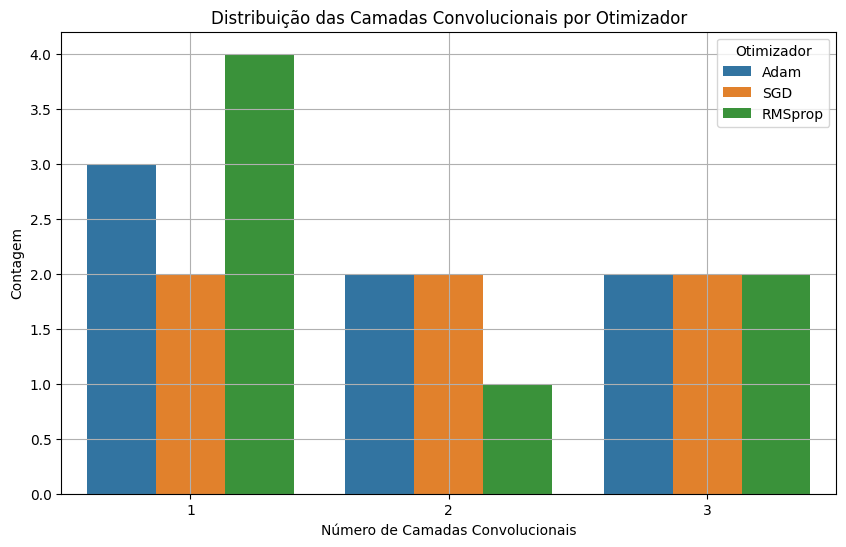

In [49]:

plt.figure(figsize=(10, 6))
sns.countplot(x='params_num_conv_layers', hue='params_optimizer', data=df)
plt.title('Distribuição das Camadas Convolucionais por Otimizador')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Contagem')
plt.legend(title='Otimizador')
plt.grid(True)
plt.show()

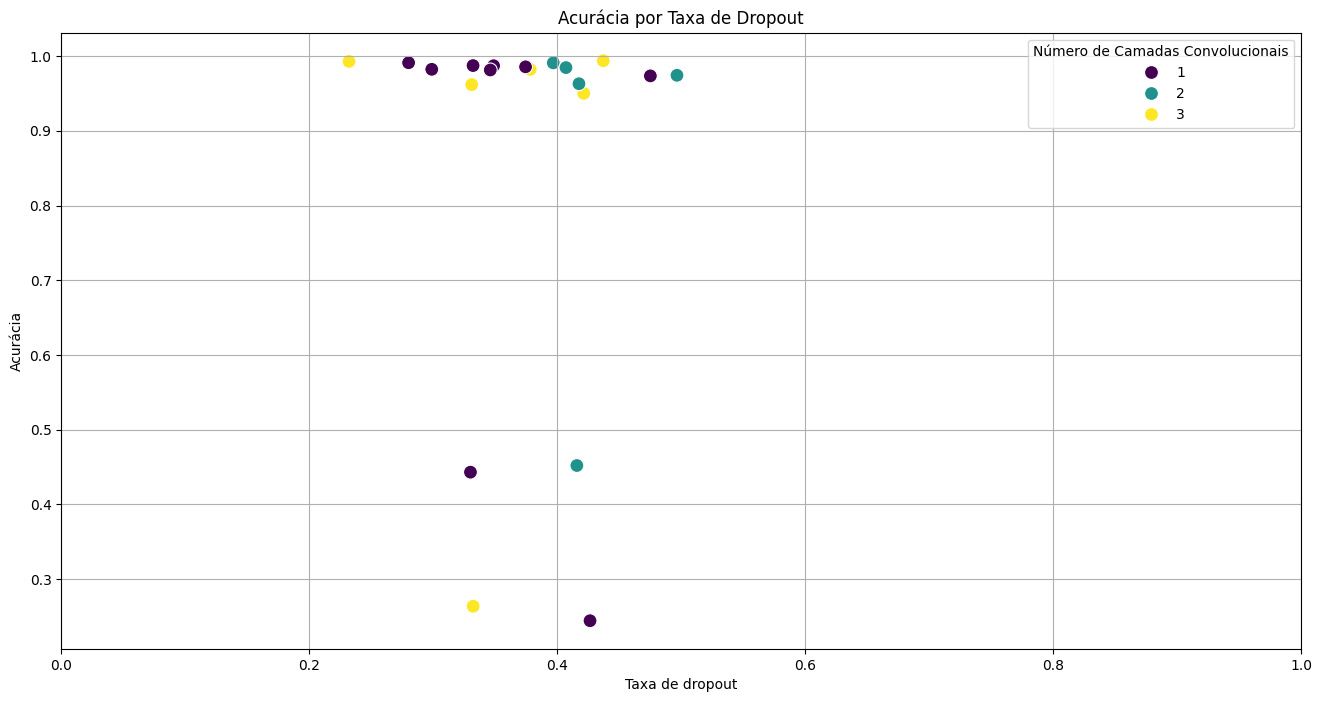

In [50]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_drop_conv2', y='user_attrs_accuracy', hue='params_num_conv_layers', palette='viridis'
                , s=100)

plt.title('Acurácia por Taxa de Dropout')
plt.xlabel('Taxa de dropout')
plt.ylabel('Acurácia')
plt.xlim(0.0, 1)
plt.grid(True)
plt.legend(title='Número de Camadas Convolucionais', loc='upper right')

plt.show()